<a href="https://colab.research.google.com/github/gutiel2/Machine-Learning-Engineering/blob/main/MLE_HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Mateo Gutierrez
RIN: 66200635
MLE - HW 6
"""

Feature matrix shape: (178, 13)
Target vector shape: (178,)
Shape of X after PCA: (178, 2)
Explained variance ratio of PC1 and PC2: [0.36198848 0.1920749 ]
Sum of explained variance (PC1 + PC2): 0.5540633835693527
SVM accuracy on test set (using 2D PCA): 0.9444444444444444

Classification report (SVM on 2D PCA):
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        24
           1       0.93      0.93      0.93        29
           2       1.00      1.00      1.00        19

    accuracy                           0.94        72
   macro avg       0.95      0.95      0.95        72
weighted avg       0.94      0.94      0.94        72

Decision Tree accuracy on test set (original features): 0.9861111111111112

Classification report (Decision Tree on original features):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.97      0.98        29
      

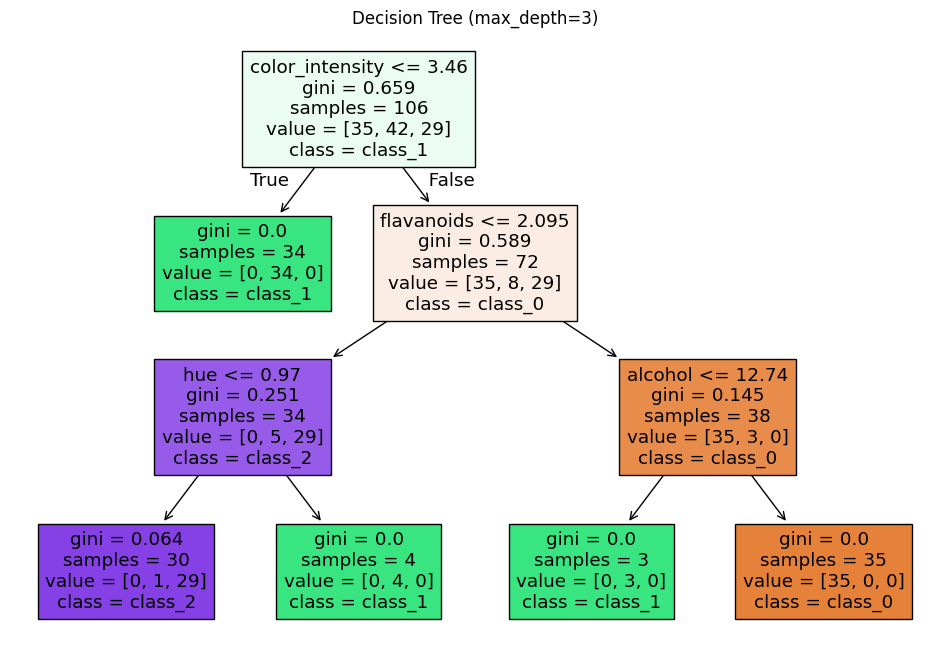

In [9]:
# Question 1

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the wine dataset
wine = load_wine()
X = wine.data
y = wine.target

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA on the scaled data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Shape of X after PCA:", X_pca.shape)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio of PC1 and PC2:", explained_variance)
print("Sum of explained variance (PC1 + PC2):", explained_variance.sum())

# Question 1c: Train SVM on PCA-transformed data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.4, random_state=42, stratify=y
)

svm_clf = SVC(kernel='linear', C=1, random_state=42)
svm_clf.fit(X_train_pca, y_train)
y_pred_svm = svm_clf.predict(X_test_pca)

acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM accuracy on test set (using 2D PCA):", acc_svm)
print("\nClassification report (SVM on 2D PCA):")
print(classification_report(y_test, y_pred_svm))

# Question 1d: Train Decision Tree on original features
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train_orig, y_train_orig)
y_pred_tree = tree_clf.predict(X_test_orig)

acc_tree = accuracy_score(y_test_orig, y_pred_tree)
print("Decision Tree accuracy on test set (original features):", acc_tree)
print("\nClassification report (Decision Tree on original features):")
print(classification_report(y_test_orig, y_pred_tree))

# Question 1e: Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_clf, feature_names=wine.feature_names, class_names=wine.target_names, filled=True)
plt.title("Decision Tree (max_depth=3)")
plt.show()

Combined data shape: (60000, 32, 32, 3) (60000,)
Feature matrix shape: (60000, 3072)
Importances array shape: (3072,)


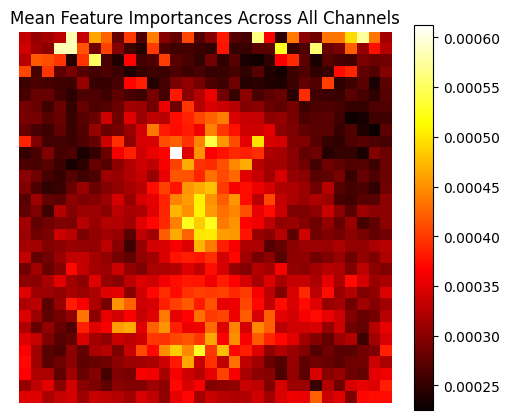

In [10]:
# Question 2
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

y = y.ravel()

print("Combined data shape:", X.shape, y.shape)

num_samples = X.shape[0]
X_reshaped = X.reshape(num_samples, -1)
print("Feature matrix shape:", X_reshaped.shape)

rf = RandomForestClassifier(
    n_estimators=50,
    random_state=42,
    )
rf.fit(X_reshaped, y)

importances = rf.feature_importances_
print("Importances array shape:", importances.shape)

importances_img = importances.reshape(32, 32, 3)

# Average across channels for a single heatmap
importances_mean = importances_img.mean(axis=2)
plt.figure(figsize=(6, 5))
plt.imshow(importances_mean, cmap='hot')
plt.title("Mean Feature Importances Across All Channels")
plt.colorbar()
plt.axis('off')
plt.show()

In [14]:
# Question 3
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

drive.mount('/content/drive', force_remount=True)

file_path = '/content/drive/My Drive/Colab/surface_temp.npy'
data = np.load(file_path)

train_data = data[:900]
test_data  = data[900:]

def create_sequences(series, input_length=20, forecast_horizon=10):
    """
    Returns X, y arrays for supervised learning.
    X[i] will be the data[i : i+input_length]
    y[i] will be the data[i+input_length : i+input_length+forecast_horizon]
    """
    X, y = [], []
    for i in range(len(series) - input_length - forecast_horizon + 1):
        X.append(series[i : i + input_length])
        y.append(series[i + input_length : i + input_length + forecast_horizon])
    return np.array(X), np.array(y)

input_length = 30
forecast_horizon = 10

X_train, y_train = create_sequences(train_data, input_length, forecast_horizon)
X_test, y_test   = create_sequences(test_data,  input_length, forecast_horizon)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(input_length, 1)))
model.add(Dense(forecast_horizon))

model.compile(optimizer='adam', loss='mse')
model.summary()

# Training
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

test_loss = model.evaluate(X_test, y_test)
print("Test MSE:", test_loss)

y_pred = model.predict(X_test)
print("y_pred shape:", y_pred.shape)

last_sequence = data[-input_length:]
last_sequence = last_sequence.reshape((1, input_length, 1))

next_10_predictions = model.predict(last_sequence)[0]
print("Predicted next 10 timesteps:", next_10_predictions)

Mounted at /content/drive


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,546 (68.54 KB)

 Trainable params: 17,546 (68.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 160994.0625 - val_loss: 111880.8750
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 78606.8516 - val_loss: 10419.5732
Epoch 3/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 37127.8477 - val_loss: 46596.6133
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 32513.0020 - val_loss: 8824.1562
Epoch 5/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6154.6338 - val_loss: 1532.8373
Epoch 6/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1033.2053 - val_loss: 221.1306
Epoch 7/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 144.4409 - val_loss: 27.8638
Epoch 8/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.2879 - val_loss: 4.4479
Epoch 9/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6122 - val_loss: 2.0591
Epoch 10/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2546 - val_loss: 1.8346
Epoch 11/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0738 - val_loss: 1.8018
Epoch 12/150
4

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
y_pred shape: (61, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
Predicted next 10 timesteps: [373.05466 373.25717 373.54968 373.24088 372.6321  373.2966  373.48578
 374.14395 373.4604  373.0023 ]
